In [1]:
import cv2
import time
import threading
import csv
import matplotlib.pyplot as plt
from deepface import DeepFace
from collections import deque, Counter

C:\Users\mustafaasafcelik\anaconda3\envs\env_bst4\lib\site-packages\mtcnn\mtcnn.py:34: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  import pkg_resources


Sistem çalışıyor... Çıkmak için Q


Action: age: 100%|███████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 10.04it/s]


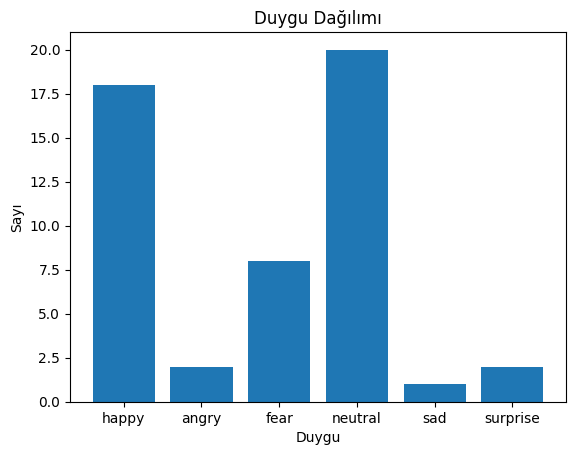

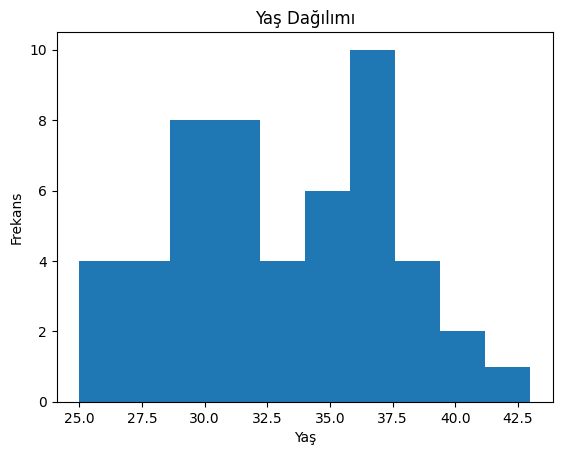

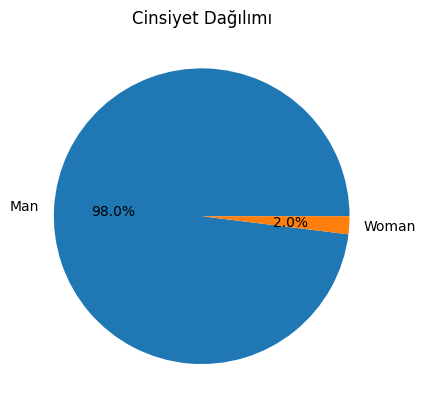

In [2]:
import cv2
import time
import threading
import csv
import matplotlib.pyplot as plt
from deepface import DeepFace
from collections import deque, Counter

# =====================================================
# GLOBAL DEĞİŞKENLER
# =====================================================
analysis_running = False

# Çoklu yüz bilgileri (her analizde güncellenir)
faces_data = []  
# faces_data içeriği:
# [
#   {
#     "emotion": "happy",
#     "gender": "Man",
#     "age": 25,
#     "box": (x, y, w, h)
#   },
#   ...
# ]

# Zamansal yumuşatma (genel – demo amaçlı)
emotion_history = deque(maxlen=5)
age_history = deque(maxlen=5)

# Grafik raporlar için tüm oturum verileri
all_emotions = []
all_ages = []
all_genders = []

# Analiz sıklığı (saniye)
ANALYSIS_INTERVAL = 1.0
last_analysis_time = 0


# =====================================================
# YARDIMCI FONKSİYONLAR
# =====================================================
def most_common(lst):
    """Listede en sık geçen değeri döndürür"""
    return max(set(lst), key=lst.count) if lst else "Waiting..."


def age_to_range(age):
    """Sayısal yaş tahminini yaş aralığına çevirir"""
    try:
        age = int(age)
    except:
        return "Unknown"

    if age < 18:
        return "0-18"
    elif age < 25:
        return "18-25"
    elif age < 35:
        return "25-35"
    elif age < 50:
        return "35-50"
    else:
        return "50+"


# =====================================================
# ÇOKLU YÜZ ANALİZİ (DERİN ÖĞRENME)
# =====================================================
def analyze_faces(frame):
    """
    Aynı karede bulunan TÜM yüzleri analiz eder.
    Her yüz için duygu, cinsiyet, yaş ve koordinat döndürür.
    """
    faces = []

    try:
        results = DeepFace.analyze(
            frame,
            actions=['emotion', 'gender', 'age'],
            enforce_detection=False
        )

        for result in results:
            emotion = result['dominant_emotion']
            gender = result['dominant_gender']
            age = result['age']

            region = result['region']
            x, y, w, h = region['x'], region['y'], region['w'], region['h']

            faces.append({
                "emotion": emotion,
                "gender": gender,
                "age": age,
                "box": (x, y, w, h)
            })

        return faces

    except Exception:
        return []


# =====================================================
# ANALİZ THREAD
# =====================================================
def analysis_thread(frame):
    global faces_data, analysis_running

    analysis_running = True

    faces = analyze_faces(frame)
    faces_data = faces

    # Grafik ve istatistik verileri
    for face in faces:
        if face["emotion"] != "Unknown":
            emotion_history.append(face["emotion"])
            all_emotions.append(face["emotion"])

        if face["age"] != "Unknown":
            age_history.append(face["age"])
            all_ages.append(face["age"])

        if face["gender"] != "Unknown":
            all_genders.append(face["gender"])

        # CSV kayıt (her yüz ayrı satır)
        with open("analysis_log.csv", "a", newline="") as f:
            writer = csv.writer(f)
            writer.writerow([
                time.ctime(),
                face["emotion"],
                face["gender"],
                face["age"]
            ])

    analysis_running = False


# =====================================================
# GRAFİK RAPORLARI (TÜRKÇE)
# =====================================================
def show_graphs():
    emotion_counts = Counter(all_emotions)
    gender_counts = Counter(all_genders)

    # Duygu Dağılımı
    plt.figure()
    plt.bar(emotion_counts.keys(), emotion_counts.values())
    plt.title("Duygu Dağılımı")
    plt.xlabel("Duygu")
    plt.ylabel("Sayı")

    # Yaş Dağılımı
    plt.figure()
    plt.hist(all_ages, bins=10)
    plt.title("Yaş Dağılımı")
    plt.xlabel("Yaş")
    plt.ylabel("Frekans")

    # Cinsiyet Dağılımı
    plt.figure()
    plt.pie(
        gender_counts.values(),
        labels=gender_counts.keys(),
        autopct="%1.1f%%"
    )
    plt.title("Cinsiyet Dağılımı")

    plt.show()


# =====================================================
# ANA PROGRAM
# =====================================================
def main():
    global last_analysis_time

    cap = cv2.VideoCapture(0)
    cap.set(cv2.CAP_PROP_FRAME_WIDTH, 640)
    cap.set(cv2.CAP_PROP_FRAME_HEIGHT, 480)

    prev_time = 0
    print("Sistem çalışıyor... Çıkmak için Q")

    while True:
        ret, frame = cap.read()
        if not ret:
            break

        # FPS
        current_time = time.time()
        fps = 1 / (current_time - prev_time) if prev_time != 0 else 0
        prev_time = current_time

        # -----------------------------
        # ZAMAN KONTROLLÜ ANALİZ
        # -----------------------------
        if (not analysis_running and
            current_time - last_analysis_time > ANALYSIS_INTERVAL):

            last_analysis_time = current_time
            threading.Thread(
                target=analysis_thread,
                args=(frame.copy(),),
                daemon=True
            ).start()

        # -----------------------------
        # TÜM YÜZLERİ ÇİZ
        # -----------------------------
        for idx, face in enumerate(faces_data):
            x, y, w, h = face["box"]
            age_range = age_to_range(face["age"])

            cv2.rectangle(frame, (x, y), (x + w, y + h),
                          (0, 255, 0), 2)

            cv2.putText(
                frame,
                f"{face['emotion']} | {face['gender']} | {age_range}",
                (x, y - 10),
                cv2.FONT_HERSHEY_SIMPLEX,
                0.6,
                (255, 255, 255),
                2
            )

        # FPS
        cv2.putText(frame, f"FPS: {int(fps)}", (30, 40),
                    cv2.FONT_HERSHEY_SIMPLEX, 0.9,
                    (255, 255, 255), 2)

        cv2.imshow("DeepFace - Çoklu Yüz Analizi", frame)

        if cv2.waitKey(1) & 0xFF == ord("q"):
            break

    cap.release()
    cv2.destroyAllWindows()
    show_graphs()


# =====================================================
# PROGRAM BAŞLANGICI
# =====================================================
if __name__ == "__main__":
    main()
